# Train your own object detector

In [2]:
import gluoncv as gcv
import mxnet as mx

## Prepare Dataset

In [3]:
import os

class DetectionDataset(gcv.data.VOCDetection):
    CLASSES = ['cocacola', 'juice', 'noodles', 'hand']  # , 'cocacola-zero'
    def __init__(self, root):
        self._im_shapes = {}
        self._root = os.path.expanduser(root)
        self._transform = None
        self._items = [(self._root, x.strip('.xml')) for x in os.listdir(self._root) if x.endswith('.xml')]
        self._anno_path = os.path.join('{}', '{}.xml')
        self._image_path = os.path.join('{}', '{}.jpg')
        self.index_map = dict(zip(self.classes, range(self.num_class)))
        self._label_cache = self._preload_labels()
        
    def __str__(self):
        detail = self._root
        return self.__class__.__name__ + '(' + detail + ')'
    
    @property
    def classes(self):
        return self.CLASSES
    
    @property
    def num_class(self):
        return len(self.classes)
        
train_dataset = DetectionDataset('../images/v4')
print('class_names:', train_dataset.classes)
print('num_images:', len(train_dataset))

class_names: ['cocacola', 'juice', 'noodles', 'hand']
num_images: 117


## Visualize data

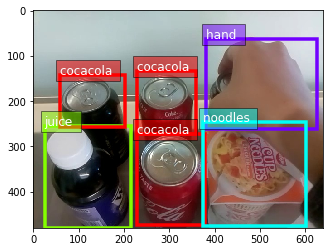

In [4]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

sample = train_dataset[0]
train_image, train_label = sample

ax = viz.plot_bbox(
    train_image.asnumpy(),
    train_label[:, :4],
    labels=train_label[:, 4:5],
    class_names=train_dataset.classes)
plt.show()


## Define Training procedure

In [5]:
import time
from tqdm import tqdm
from datetime import datetime
from mxnet import autograd
from gluoncv.data.batchify import Tuple, Stack, Pad

def train_model(train_dataset, epochs=50, resume_net=None):
    ctx = mx.gpu(0)
    if resume_net is not None:
        net = resume_net
    else:
        net = gcv.model_zoo.get_model('yolo3_darknet53_custom', classes=train_dataset.classes, transfer='coco')
    net.collect_params().reset_ctx(ctx)
    width, height = 512, 512  # suppose we use 512 as base training size
    gcv.utils.random.seed(233)
    
    batch_size = 16  # 16 for p3.2xlarge, 8 for p2.2xlarge
    # you can make it larger(if your CPU has more cores) to accelerate data loading
    num_workers = 4

    train_transform = gcv.data.transforms.presets.yolo.YOLO3DefaultTrainTransform(width, height, net)
    batchify_fn = Tuple(*([Stack() for _ in range(6)] + [Pad(axis=0, pad_val=-1) for _ in range(1)]))
    train_loader = mx.gluon.data.DataLoader(
        train_dataset.transform(train_transform),
        batch_size,
        shuffle=True,
        batchify_fn=batchify_fn,
        last_batch='rollover',
        num_workers=num_workers)
    
    sigmoid_ce = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
    l1_loss = mx.gluon.loss.L1Loss()
    obj_metrics = mx.metric.Loss('ObjLoss')
    center_metrics = mx.metric.Loss('BoxCenterLoss')
    scale_metrics = mx.metric.Loss('BoxScaleLoss')
    cls_metrics = mx.metric.Loss('ClassLoss')
    for k, v in net.collect_params().items():
        if 'yolodetectionblock' not in k and 'yolooutput' not in k:
            # freeze upper layers
            v.grad_req = 'null'
    trainer = mx.gluon.Trainer(
        net.collect_params(), 'sgd',
        {'learning_rate': 0.0005, 'wd': 0.0005, 'momentum': 0.9})  # 'learning_rate': 0.001
    
    net.hybridize(static_alloc=True, static_shape=True)
    
    for epoch in range(epochs):
        tic = time.time()
        btic = time.time()
        
        tbar = tqdm(train_loader)
        for i, batch in enumerate(tbar):
            batch_size = batch[0].shape[0]
            data = mx.gluon.utils.split_and_load(batch[0], ctx_list=[ctx], batch_axis=0)
            # objectness, center_targets, scale_targets, weights, class_targets
            fixed_targets = [mx.gluon.utils.split_and_load(batch[it], ctx_list=[ctx], batch_axis=0) for it in range(1, 6)]
            gt_boxes = mx.gluon.utils.split_and_load(batch[6], ctx_list=[ctx], batch_axis=0)
            sum_losses = []
            obj_losses = []
            center_losses = []
            scale_losses = []
            cls_losses = []
            
            with autograd.record():
                for ix, x in enumerate(data):
                    obj_loss, center_loss, scale_loss, cls_loss = net(x, gt_boxes[ix], *[ft[ix] for ft in fixed_targets])
                    sum_losses.append(obj_loss + center_loss + scale_loss + cls_loss)
                    obj_losses.append(obj_loss)
                    center_losses.append(center_loss)
                    scale_losses.append(scale_loss)
                    cls_losses.append(cls_loss)
                autograd.backward(sum_losses)
            trainer.step(batch_size)
            obj_metrics.update(0, obj_losses)
            center_metrics.update(0, center_losses)
            scale_metrics.update(0, scale_losses)
            cls_metrics.update(0, cls_losses)
            name1, loss1 = obj_metrics.get()
            name2, loss2 = center_metrics.get()
            name3, loss3 = scale_metrics.get()
            name4, loss4 = cls_metrics.get()
            tbar.set_description('[Epoch {}][Batch {}], LR: {:.2E}, Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
                    epoch, i, trainer.learning_rate, batch_size/(time.time()-btic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))
            btic = time.time()
    return net
        


## Start Training!!

In [6]:
epochs = 200
resume = None
if resume is not None:
    resume_net = gcv.model_zoo.get_model('yolo3_darknet53_custom', classes=train_dataset.classes, transfer='coco')
    net.load_parameters(resume)  # continue training
else:
    resume_net = None
net = train_model(train_dataset, epochs=epochs, resume_net=resume_net)
save_file = 'object_detector_epoch{}_{}.params'.format(epochs, datetime.now().strftime("%m_%d_%Y_%H_%M_%S"))
net.save_parameters(save_file)
print('Saved model to disk: ' + save_file)

[Epoch 0][Batch 6], LR: 5.00E-04, Speed: 97.641 samples/sec, ObjLoss=1739.566, BoxCenterLoss=9.682, BoxScaleLoss=4.920, ClassLoss=9.495: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]  
[Epoch 1][Batch 6], LR: 5.00E-04, Speed: 97.004 samples/sec, ObjLoss=887.084, BoxCenterLoss=9.494, BoxScaleLoss=3.962, ClassLoss=8.882: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it] 
[Epoch 2][Batch 6], LR: 5.00E-04, Speed: 96.099 samples/sec, ObjLoss=602.086, BoxCenterLoss=9.432, BoxScaleLoss=3.383, ClassLoss=8.524: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
[Epoch 3][Batch 7], LR: 5.00E-04, Speed: 96.064 samples/sec, ObjLoss=448.168, BoxCenterLoss=9.437, BoxScaleLoss=3.048, ClassLoss=8.294: 100%|██████████| 8/8 [00:09<00:00,  1.16s/it]
[Epoch 4][Batch 6], LR: 5.00E-04, Speed: 22.174 samples/sec, ObjLoss=368.371, BoxCenterLoss=9.304, BoxScaleLoss=2.830, ClassLoss=7.980: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]
[Epoch 5][Batch 6], LR: 5.00E-04, Speed: 97.126 samples/sec, ObjLoss=313.463, BoxCente

[Epoch 44][Batch 7], LR: 5.00E-04, Speed: 16.775 samples/sec, ObjLoss=50.890, BoxCenterLoss=8.741, BoxScaleLoss=1.858, ClassLoss=4.409: 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]
[Epoch 45][Batch 6], LR: 5.00E-04, Speed: 97.160 samples/sec, ObjLoss=49.952, BoxCenterLoss=8.744, BoxScaleLoss=1.853, ClassLoss=4.380: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]
[Epoch 46][Batch 6], LR: 5.00E-04, Speed: 94.555 samples/sec, ObjLoss=49.041, BoxCenterLoss=8.739, BoxScaleLoss=1.848, ClassLoss=4.355: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]
[Epoch 47][Batch 7], LR: 5.00E-04, Speed: 97.502 samples/sec, ObjLoss=48.059, BoxCenterLoss=8.729, BoxScaleLoss=1.848, ClassLoss=4.325: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it]
[Epoch 48][Batch 6], LR: 5.00E-04, Speed: 97.193 samples/sec, ObjLoss=47.225, BoxCenterLoss=8.717, BoxScaleLoss=1.843, ClassLoss=4.292: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]
[Epoch 49][Batch 6], LR: 5.00E-04, Speed: 40.275 samples/sec, ObjLoss=46.416, BoxCenterLos

[Epoch 89][Batch 7], LR: 5.00E-04, Speed: 6.150 samples/sec, ObjLoss=27.881, BoxCenterLoss=8.503, BoxScaleLoss=1.672, ClassLoss=3.394: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it] 
[Epoch 90][Batch 6], LR: 5.00E-04, Speed: 64.769 samples/sec, ObjLoss=27.628, BoxCenterLoss=8.500, BoxScaleLoss=1.668, ClassLoss=3.376: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]
[Epoch 91][Batch 6], LR: 5.00E-04, Speed: 16.580 samples/sec, ObjLoss=27.384, BoxCenterLoss=8.493, BoxScaleLoss=1.664, ClassLoss=3.362: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]
[Epoch 92][Batch 7], LR: 5.00E-04, Speed: 96.602 samples/sec, ObjLoss=27.108, BoxCenterLoss=8.486, BoxScaleLoss=1.661, ClassLoss=3.343: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
[Epoch 93][Batch 6], LR: 5.00E-04, Speed: 12.353 samples/sec, ObjLoss=26.865, BoxCenterLoss=8.482, BoxScaleLoss=1.658, ClassLoss=3.328: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
[Epoch 94][Batch 6], LR: 5.00E-04, Speed: 18.440 samples/sec, ObjLoss=26.630, BoxCenterLos

[Epoch 133][Batch 6], LR: 5.00E-04, Speed: 96.410 samples/sec, ObjLoss=19.910, BoxCenterLoss=8.288, BoxScaleLoss=1.599, ClassLoss=2.755: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]
[Epoch 134][Batch 7], LR: 5.00E-04, Speed: 21.606 samples/sec, ObjLoss=19.775, BoxCenterLoss=8.282, BoxScaleLoss=1.597, ClassLoss=2.741: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
[Epoch 135][Batch 6], LR: 5.00E-04, Speed: 10.036 samples/sec, ObjLoss=19.657, BoxCenterLoss=8.280, BoxScaleLoss=1.596, ClassLoss=2.731: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]
[Epoch 136][Batch 6], LR: 5.00E-04, Speed: 96.145 samples/sec, ObjLoss=19.537, BoxCenterLoss=8.275, BoxScaleLoss=1.593, ClassLoss=2.717: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
[Epoch 137][Batch 7], LR: 5.00E-04, Speed: 91.389 samples/sec, ObjLoss=19.406, BoxCenterLoss=8.272, BoxScaleLoss=1.589, ClassLoss=2.703: 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]
[Epoch 138][Batch 6], LR: 5.00E-04, Speed: 94.823 samples/sec, ObjLoss=19.292, BoxCen

[Epoch 177][Batch 6], LR: 5.00E-04, Speed: 96.923 samples/sec, ObjLoss=15.706, BoxCenterLoss=8.147, BoxScaleLoss=1.525, ClassLoss=2.271: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]
[Epoch 178][Batch 6], LR: 5.00E-04, Speed: 96.375 samples/sec, ObjLoss=15.635, BoxCenterLoss=8.145, BoxScaleLoss=1.525, ClassLoss=2.262: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
[Epoch 179][Batch 7], LR: 5.00E-04, Speed: 97.376 samples/sec, ObjLoss=15.556, BoxCenterLoss=8.141, BoxScaleLoss=1.524, ClassLoss=2.253: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]
[Epoch 180][Batch 6], LR: 5.00E-04, Speed: 13.972 samples/sec, ObjLoss=15.491, BoxCenterLoss=8.138, BoxScaleLoss=1.525, ClassLoss=2.244: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
[Epoch 181][Batch 6], LR: 5.00E-04, Speed: 29.369 samples/sec, ObjLoss=15.426, BoxCenterLoss=8.136, BoxScaleLoss=1.524, ClassLoss=2.236: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
[Epoch 182][Batch 7], LR: 5.00E-04, Speed: 96.258 samples/sec, ObjLoss=15.347, BoxCen

Saved model to disk: object_detector_epoch200_11_08_2019_21_56_15.params
